# Dynamic-TDA with HFD Testing: Application to EEG Signals

In [24]:
##### Basic but very useful libraries #####
###########################################
import numpy as np                 # For handling arrays
import matplotlib.pyplot as plt    # For visualization
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')

##### Main TDA libraries #####
##############################
# pip install ripser
from ripser import ripser          # For computing persistence cohomology
# pip install ripser
import persim                      # For handling and visualizing persistence diagrams
from persim import landscapes
# pip install tadasets
from tadasets import sphere, torus # For generating simple but interesting datasets

##### Fractal analysis #####
############################

# pip install hfda
import hfda                        # For computing Higushi Fractal Dimension

In [25]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### Sliding-Window Embedding (SWE) of EEG Epileptic Seizure Data

We are interested in the dynamics of the brain activity before, during and after an epileptic seizure. We follow the sliding window embedding approach to analyze the EEG signal.

<center>
$
\begin{align*}
    x(t) & = [x_1(t), ..., x_p(t)]' &&\in \mathbb{R}^p, \hspace{2mm} t = 1, ..., T \\
    X(t) & = [x(t), x(t-1), ..., x(t-(\omega-1))] &&\in \mathbb{R}^{p\times \omega}, \hspace{2mm} t = m, ..., T
\end{align*}
$
</center>

In [26]:
TS = np.array(
    [np.loadtxt('./Epileptic Seizure EEG Dataset/ch{:02d}.inp'.format(i)) for i in range(1, 22) if i not in [11, 12, 20]]
).T
TS -= TS.mean(axis=0)
TS /= TS.std(axis=0)

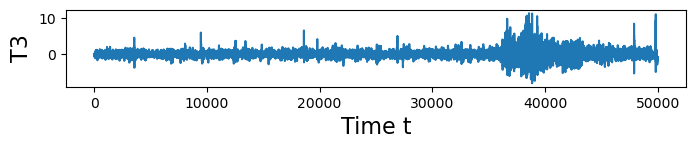

In [27]:
plt.figure(figsize=(8, 1))
plt.plot(TS[:, 12])
plt.ylabel('T3', fontsize=16)
plt.xlabel('Time t', fontsize=16)
plt.show()

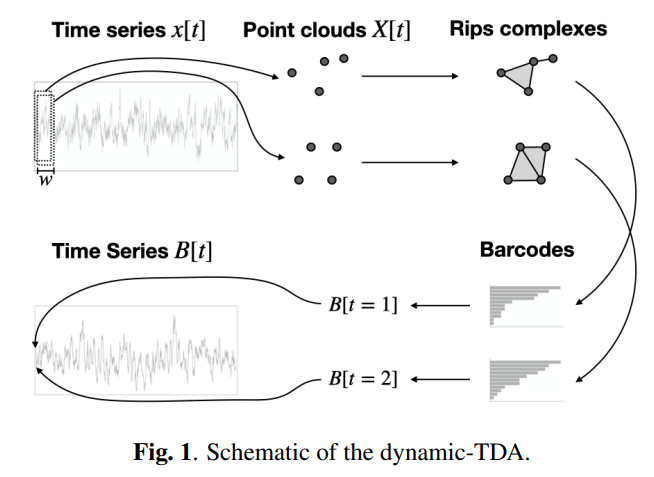

Songdechakraiwut and Chung (2020)

In [28]:
def getTotalPersistence(dgm, dim=0):
    """
    Parameters
    ----------
    dgm : list of arrays
       Each array consists of (birth, death) pairs representing the scales at which a topological features appears.
    dim : int
       Specifies the dimension to be analyzed, i.e., the array on which we compute total persistence.

    Returns
    -------
    total_persistence : float
       The total persistence (sum of death minus birth times) for features of dimension dim.
    """

    total_persistence = 0
    for b, d in dgm[dim]:
        if d != float("inf"): 
            total_persistence += d - b
    
    return total_persistence

In [70]:
T, P = TS.shape
SW = 120 # 80, 90, 100, 110, 120

TP_0 = []
TP_1 = []
TP_2 = []

for i_s, i_e in zip(range(0, T-SW, SW), range(SW, T, SW)):
    # Sliding window emedding
    SW_data = TS[i_s:i_e]
    SW_tda = ripser(X=SW_data, maxdim=2)
    SW_diagrams = SW_tda['dgms']
    # Computing total persistence
    total_persistence_0 = getTotalPersistence(SW_diagrams, dim=0)
    total_persistence_1 = getTotalPersistence(SW_diagrams, dim=1)
    total_persistence_2 = getTotalPersistence(SW_diagrams, dim=2)
    # Storing total persistence
    TP_0.append(total_persistence_0)
    TP_1.append(total_persistence_1)
    TP_2.append(total_persistence_2)    

TP_0 = np.array(TP_0)
TP_1 = np.array(TP_1)
TP_2 = np.array(TP_2)

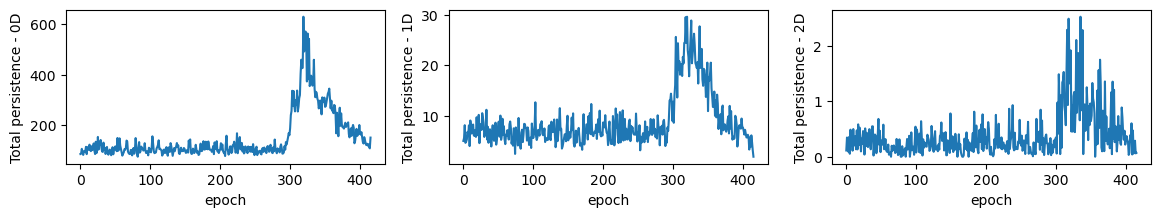

In [71]:
plt.figure(figsize=(14, 2))
plt.subplot(131)
plt.plot(TP_0)
plt.xlabel('epoch')
plt.ylabel('Total persistence - 0D')
plt.subplot(132)
plt.plot(TP_1)
plt.xlabel('epoch')
plt.ylabel('Total persistence - 1D')
plt.subplot(133)
plt.plot(TP_2)
plt.xlabel('epoch')
plt.ylabel('Total persistence - 2D')
plt.show()

### Statistical inference for Dynamic TDA 

Given the time-varying plots above of total persistence. Our goal is to carry out statistical inference and study the significance of the observed change in the total persistence. Namely, we would like to answer the following questions:
- Does the time series of total persistence have a change point?
- How significant is this change point?
- At what time does the change point occur?

- Define the deviations in total persistence as:
$$D_t = TP_t - \hat{\mu}_t.$$
- Define the cumulative sum of deviations as:
$$S_t = S_{t-1} + D_t.$$

- Define the null hypothesis to be:
$$H_0: \text{There is no structural change in } D_t.$$

To be able to carry out statistical testing under the null. We present a novel testing framework based on fractal analysis. The key idea is as follows: Under the null hypothesis that there is no structural breaks in the observed time series of deviations, we can then safely permute the time series without ruining the mean structure. Thus, after permuting the deviations. The cumulative sum of deviations must behave similarly to random walks. To measurs deviations from the null, we use Higushi Fractal Dimension.

Let the k-level length of the sum of deviations curve be:
$$L_m(k) = \frac{T-1}{\lfloor\frac{N-m}{k} \rfloor k^2} \sum_{t=1}^{\lfloor\frac{N-m}{k} \rfloor} \big| D(m+tk) - D(m+(t-1) k)\big|,$$
$$L(k) = \frac{1}{k} \sum_{m=1}^{k} L_m(k) \hspace{59mm}.$$

Then we define the Higuchi fractal dimension of the sum of deviations' time-series to be the slope of the best-fitting linear function through the data points $\big\{\big(log L(k), log \frac{1}{k} \big) \big\}$. In simple words, the Higuchi approach assumes that the legth curve $L(k)$ follows the following relationship:
$$L(k)\propto \exp \big\{ - HFD \times \log(k) \big\} = k^{-HFD},$$
where $HFD$ is the Higuchi fractal dimension of the time series.

A smooth curve in $\mathbb{R}^2$ has Higuchi fractal dimension $1$. However, a random walk or Brownian motion which is not smooth, has Higuchi fractal dimension of $1.5$. Therefore, the Higuchi fractal dimension can be used to assess deviations from a random walk.

In [72]:
W = 50 # 5
TP_0_DET = np.zeros(len(TP_0))
TP_1_DET = np.zeros(len(TP_1))
TP_2_DET = np.zeros(len(TP_2))

# Detrending the first W points
TP_0_DET[:W] = TP_0[:W] - sum(TP_0[:W])/W
TP_1_DET[:W] = TP_1[:W] - sum(TP_1[:W])/W
TP_2_DET[:W] = TP_2[:W] - sum(TP_2[:W])/W

# Detrending the entire time series
for b in range(W, len(TP_0)):
    TP_0_DET[b] = TP_0[b] - sum(TP_0[b-W:b])/W
    TP_1_DET[b] = TP_1[b] - sum(TP_1[b-W:b])/W
    TP_2_DET[b] = TP_2[b] - sum(TP_2[b-W:b])/W
# TP_0_DET = (TP_0 - TP_0.mean()) / TP_0.std()
# TP_1_DET = (TP_1 - TP_1.mean()) / TP_1.std()
# TP_2_DET = (TP_2 - TP_2.mean()) / TP_2.std()

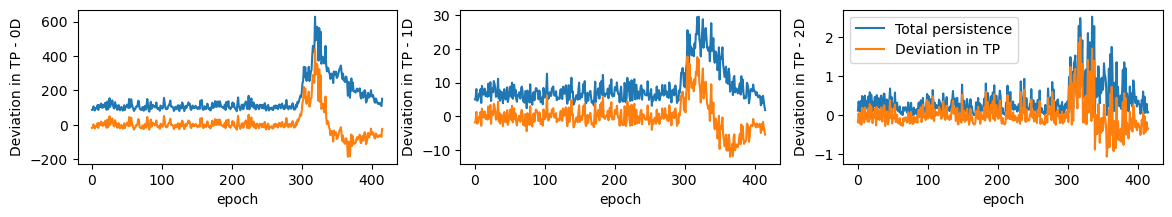

In [73]:
plt.figure(figsize=(14, 2))
plt.subplot(131)
plt.plot(TP_0)
plt.plot(TP_0_DET)
plt.xlabel('epoch')
plt.ylabel('Deviation in TP - 0D')
plt.subplot(132)
plt.plot(TP_1)
plt.plot(TP_1_DET)
plt.xlabel('epoch')
plt.ylabel('Deviation in TP - 1D')
plt.subplot(133)
plt.plot(TP_2)
plt.plot(TP_2_DET)
plt.xlabel('epoch')
plt.ylabel('Deviation in TP - 2D')
plt.legend(('Total persistence', 'Deviation in TP'))
plt.show()

In [74]:
CUSUM_0 = np.cumsum(TP_0_DET)
CUSUM_1 = np.cumsum(TP_1_DET)
CUSUM_2 = np.cumsum(TP_2_DET)

permutation = np.random.permutation(len(TP_0_DET))

CUSUM_0_PERM = np.cumsum(TP_0_DET[permutation])
CUSUM_1_PERM = np.cumsum(TP_1_DET[permutation])
CUSUM_2_PERM = np.cumsum(TP_2_DET[permutation])

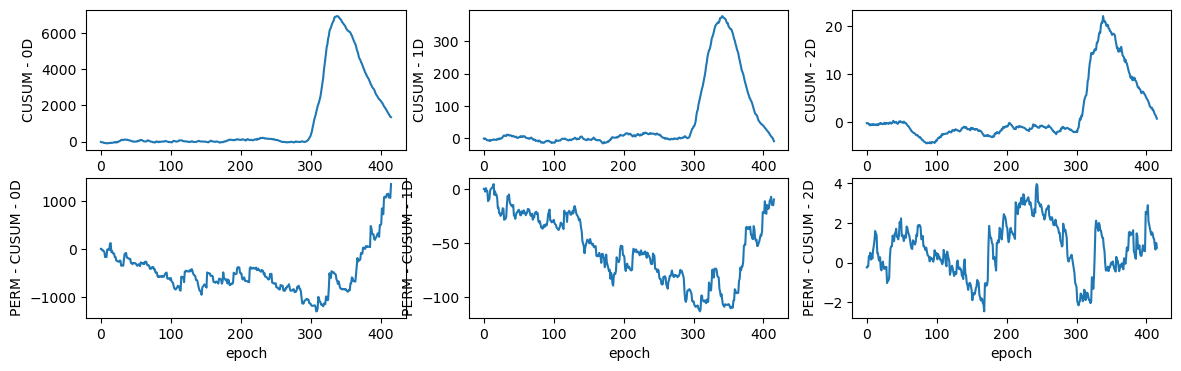

In [75]:
plt.figure(figsize=(14, 4))
plt.subplot(231)
plt.plot(CUSUM_0)
plt.xlabel('epoch')
plt.ylabel('CUSUM - 0D')
plt.subplot(232)
plt.plot(CUSUM_1)
plt.xlabel('epoch')
plt.ylabel('CUSUM - 1D')
plt.subplot(233)
plt.plot(CUSUM_2)
plt.xlabel('epoch')
plt.ylabel('CUSUM - 2D')

plt.subplot(234)
plt.plot(CUSUM_0_PERM)
plt.xlabel('epoch')
plt.ylabel('PERM - CUSUM - 0D')
plt.subplot(235)
plt.plot(CUSUM_1_PERM)
plt.xlabel('epoch')
plt.ylabel('PERM - CUSUM - 1D')
plt.subplot(236)
plt.plot(CUSUM_2_PERM)
plt.xlabel('epoch')
plt.ylabel('PERM - CUSUM - 2D')
plt.show()

In [76]:
k_max = 10

D_0 = hfda.measure(CUSUM_0.copy(), k_max)
D_1 = hfda.measure(CUSUM_1.copy(), k_max)
D_2 = hfda.measure(CUSUM_2.copy(), k_max)

In [77]:
D_0, D_1, D_2

(1.0764366389939508, 1.1258100503908508, 1.212368772187317)

In [78]:
ref_dist_hfd_0 = []
ref_dist_hfd_1 = []
ref_dist_hfd_2 = []

B = 10000
for b in range(B):
    
    permutation = np.random.permutation(len(TP_0_DET))
    
    perm_CUSUM_0 = np.cumsum(TP_0_DET[permutation])
    perm_CUSUM_1 = np.cumsum(TP_1_DET[permutation])
    perm_CUSUM_2 = np.cumsum(TP_2_DET[permutation])
    
    perm_D_0 = hfda.measure(perm_CUSUM_0, k_max)
    perm_D_1 = hfda.measure(perm_CUSUM_1, k_max)
    perm_D_2 = hfda.measure(perm_CUSUM_2, k_max)
    
    ref_dist_hfd_0.append(perm_D_0)
    ref_dist_hfd_1.append(perm_D_1)
    ref_dist_hfd_2.append(perm_D_2)
    
ref_dist_hfd_0 = np.array(ref_dist_hfd_0)
ref_dist_hfd_1 = np.array(ref_dist_hfd_1)
ref_dist_hfd_2 = np.array(ref_dist_hfd_2)

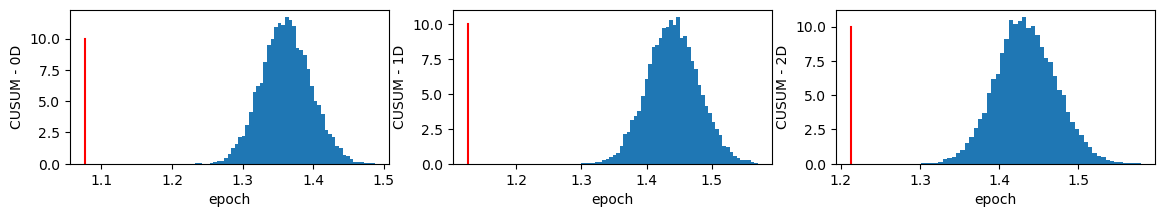

In [79]:
plt.figure(figsize=(14, 2))
plt.subplot(131)
plt.hist(ref_dist_hfd_0, bins=50, density=True)
plt.plot(50 * [D_0], np.linspace(0, 10, 50), 'r')
plt.xlabel('epoch')
plt.ylabel('CUSUM - 0D')
plt.subplot(132)
plt.hist(ref_dist_hfd_1, bins=50, density=True)
plt.plot(50 * [D_1], np.linspace(0, 10, 50), 'r')
plt.xlabel('epoch')
plt.ylabel('CUSUM - 1D')
plt.subplot(133)
plt.hist(ref_dist_hfd_2, bins=50, density=True)
plt.plot(50 * [D_2], np.linspace(0, 10, 50), 'r')
plt.xlabel('epoch')
plt.ylabel('CUSUM - 2D')
plt.show()